#### Import packages

In [1]:
import h5py
import numpy as np
import deepdish as dd

from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# load tensorflow based upon version
from tensorflow import __version__ as tf_version
if tf_version[0] == '1':
    import tensorflow as tf
    tf.enable_eager_execution()
else:
    import tensorflow.compat.v1 as tf
    tf.enable_eager_execution()

In [3]:
"""import tensorflow.compat.v1 as tf
tf.enable_eager_execution()"""

'import tensorflow.compat.v1 as tf\ntf.enable_eager_execution()'

In [4]:
from avgn.utils.paths import DATA_DIR, ensure_dir
from avgn.datasets.create_tfrecord import _bytes_feature, _float_feature, _int64_feature, serialize_example

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

### load data

In [6]:
bird = 'Bird9'
species = 'BF'
dataset = 'Koumura_Okanoya'

In [7]:
data_file = DATA_DIR / species / dataset/ 'syllable_spectrograms' / (bird + '.hdf5')
indv_data = dd.io.load(data_file)

In [8]:
# prepare the tfrecord output location
tf_record_output = DATA_DIR / species / dataset / 'syllable_tfrecord'
ensure_dir(tf_record_output)
tf_record_output

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/BF/Koumura_Okanoya/syllable_tfrecord')

### convert data to tf record

In [9]:
feature_lens = ([len(indv_data[i]) for i in indv_data.keys()])
print(feature_lens)

[13896, 13896, 13896, 13896, 13896, 13896, 13896]


In [10]:
# ensure all features are the same size
assert np.all(feature_lens)

In [11]:
n_observations = feature_lens[0]

In [12]:
tfrecord_filename = tf_record_output / (bird + '.tfrecord')
tfrecord_filename

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/AVGN_419/AVGN/data/BF/Koumura_Okanoya/syllable_tfrecord/Bird9.tfrecord')

#### This loop requires you to specify the datatype of your data, if they are not either a float or int64, you will net to convert to a bytes list

In [13]:
# loop through hdf5 of examples, save to tfrecord
with tf.python_io.TFRecordWriter(str(tfrecord_filename)) as writer:
    for exi in tqdm(range(n_observations)):

        # create an item in the datset converted to the correct formats (float, int, byte)
        example = serialize_example(
            {
                "syllable": {
                    "data": indv_data["syllables"][exi].flatten().tobytes(),
                    "_type": _bytes_feature,
                },
                "indv": {
                    "data": indv_data["indv"][exi].astype("|S7"),
                    "_type": _bytes_feature,
                },
                "orig_wav": {
                    "data": indv_data["original_wav_name"][exi].astype("|S7"),
                    "_type": _bytes_feature,
                },
                "label": {
                    "data": indv_data["syll_labels"][exi].astype("|S7"),
                    "_type": _bytes_feature,
                },
                "wav_datetime": {
                    "data": np.datetime_as_string(
                        indv_data["wav_datetime"][exi]
                    ).astype("|S26"),
                    "_type": _bytes_feature,
                },
                "length_s": {
                    "data": indv_data["syll_lengths"][exi],
                    "_type": _float_feature,
                },
                "syll_start_rel_wav": {
                    "data": indv_data["syll_start_rel_wav"][exi],
                    "_type": _float_feature,
                },
            }
        )
        # write the defined example into the dataset
        writer.write(example)

        # exit after 10 iterations because this is just a test
        # if exi == 10:
        #    break

## A few ways to read the dataset

#### test read dataset with tensorflow datasets

In [14]:
# list of filenames
filenames = [str(tfrecord_filename)]

In [15]:
# dataset class https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset
raw_dataset = tf.data.TFRecordDataset(filenames)

In [16]:
# create a 'Dataset' with at most 'count' elements
dset = raw_dataset.take(count=10)

In [17]:
# grab a single element from that dataset
element = list(dset)[1]
# a "Feature message" https://www.tensorflow.org/api_docs/python/tf/train/Example
example = tf.train.Example()
# parse the element in to the example message
example.ParseFromString(element.numpy())
list(example.features.feature)

['wav_datetime',
 'orig_wav',
 'indv',
 'label',
 'syll_start_rel_wav',
 'length_s',
 'syllable']

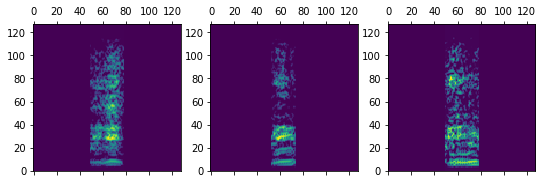

In [18]:
fig, ax = plt.subplots(ncols = 3, figsize=(9,3))
for i in range(3):
    # grab a single element from that dataset
    element = list(dset)[i]
    # a "Feature message" https://www.tensorflow.org/api_docs/python/tf/train/Example
    example = tf.train.Example()
    # parse the element in to the example message
    example.ParseFromString(element.numpy())
    # subset the syllable
    syll_buff = dict(example.features.feature)['syllable']
    # convert the buffer into a uint8
    syll = tf.io.decode_raw(syll_buff.bytes_list.value[0], tf.uint8).numpy().reshape(128,128)
    # show the image
    ax[i].matshow(syll,origin='lower')

#### Test read tfrecord with python io (tensorflow < 2 only)

In [19]:
# create an iterator over items in the dataset
record_iterator = tf.python_io.tf_record_iterator(path=str(tfrecord_filename))

W0501 13:26:01.111595 140706436044544 deprecation.py:323] From <ipython-input-19-5c8492118905>:2: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


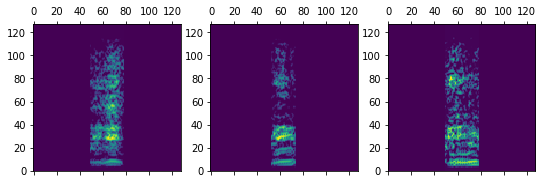

In [20]:
fig, ax = plt.subplots(ncols = 3, figsize=(9,3))
for i in range(3):
    # get the next item in the tfrecord
    string_record = record_iterator.__next__()
    # create example object
    example = tf.train.Example()
    # parse example from the record
    example.ParseFromString(string_record)
    # grab the syllable
    test = dict(example.features.feature)['syllable']
    # convert from buffer
    syll = np.frombuffer(test.bytes_list.value[0], dtype=np.uint8).reshape(128,128)
    # show image
    ax[i].matshow(syll,origin='lower')

### read the dataset by parsing

In [21]:
# https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/2017/examples/09_tfrecord_example.py

In [22]:
# list of filenames
filenames = [str(tfrecord_filename)]

In [23]:
raw_dataset = tf.data.TFRecordDataset(filenames)

In [24]:
def _dtype_to_tf_feattype(dtype):
    """ reads from tfrecord in the three supported feature formats
    """
    if dtype is tf.float32:
        return tf.float32
    elif dtype is tf.string:
        return tf.string
    elif dtype is tf.int64:
        return tf.int64
    else:
        return tf.string
    

def _parse_function(example_proto, labels, dtypes):
    """ parse dataset from tfrecord, and convert to correct format
    """
    # list features
    features = {
        lab: tf.FixedLenFeature([], _dtype_to_tf_feattype(dtype))
        for lab, dtype in zip(labels, dtypes)
    }
    # parse features
    parsed_features = tf.parse_single_example(example_proto, features)
    
    parse_list = []
    for lab, dtype in zip(labels, dtypes):
        if dtype not in [tf.float32, tf.string, tf.int64]:
            parse_list.append(tf.decode_raw(parsed_features[lab], dtype))    
        else:
            parse_list.append(parsed_features[lab])
    return parse_list

In [25]:
ds_labs = ['syllable', 'indv', 'label', 'length_s', 'orig_wav', 'syll_start_rel_wav', 'wav_datetime']
ds_dtype = [tf.uint8, tf.string, tf.string, tf.float32, tf.string, tf.float32, tf.string]

In [26]:
dset = raw_dataset.map(lambda x: _parse_function(x, labels=ds_labs, dtypes= ds_dtype))

In [27]:
dataset = dset.shuffle(buffer_size=10000)
dataset = dataset.batch(2)
iterator = dataset.make_one_shot_iterator()

W0501 13:26:02.255625 140706436044544 deprecation.py:323] From <ipython-input-27-2db9fe91b0d0>:3: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [28]:
iterator.get_next()

(<tf.Tensor: id=134, shape=(2, 16384), dtype=uint8, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)>,
 <tf.Tensor: id=135, shape=(2,), dtype=string, numpy=array([b'Bird9', b'Bird9'], dtype=object)>,
 <tf.Tensor: id=136, shape=(2,), dtype=string, numpy=array([b'syll', b'syll'], dtype=object)>,
 <tf.Tensor: id=137, shape=(2,), dtype=float32, numpy=array([0.052, 0.084], dtype=float32)>,
 <tf.Tensor: id=138, shape=(2,), dtype=string, numpy=array([b'/mnt/cu', b'/mnt/cu'], dtype=object)>,
 <tf.Tensor: id=139, shape=(2,), dtype=float32, numpy=array([ 1.621, 13.019], dtype=float32)>,
 <tf.Tensor: id=140, shape=(2,), dtype=string, numpy=
 array([b'1900-02-09T19:00:00.000000', b'1900-02-09T16:00:00.000000'],
       dtype=object)>)

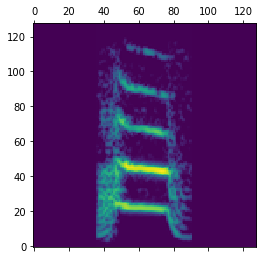

In [29]:
plt.matshow(iterator.get_next()[0][0].numpy().reshape((128,128)), origin='lower')